## 1- Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.neighbors import NearestNeighbors #NearestNeighbors: For building the recommendation model using K-Nearest Neighbors.
from scipy.sparse import csr_matrix #csr_matrix: Efficiently handle sparse data.


## 2- EDA

In [2]:
movie_df = pd.read_csv('movie.csv')
ratings_df = pd.read_csv('rating.csv')

In [3]:
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [5]:
print(movie_df.shape, ratings_df.shape)

(27278, 3) (20000263, 4)


In [6]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [7]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [8]:
movie_df.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [9]:
ratings_df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [10]:
movie_df.duplicated().sum()

0

In [11]:
ratings_df.duplicated().sum()

0

- merging the two datasets by movieID the common cloumn

In [12]:
df = movie_df.merge(ratings_df, how="left", on="movieId")
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6.0,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.5,2009-01-02 01:13:41


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000797 entries, 0 to 20000796
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   title      object 
 2   genres     object 
 3   userId     float64
 4   rating     float64
 5   timestamp  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 1.0+ GB


In [14]:
print('Number of Users: {}, Number of movies:{}'.format(len(df.userId.unique()),len(df.title.unique())))

Number of Users: 138494, Number of movies:27262


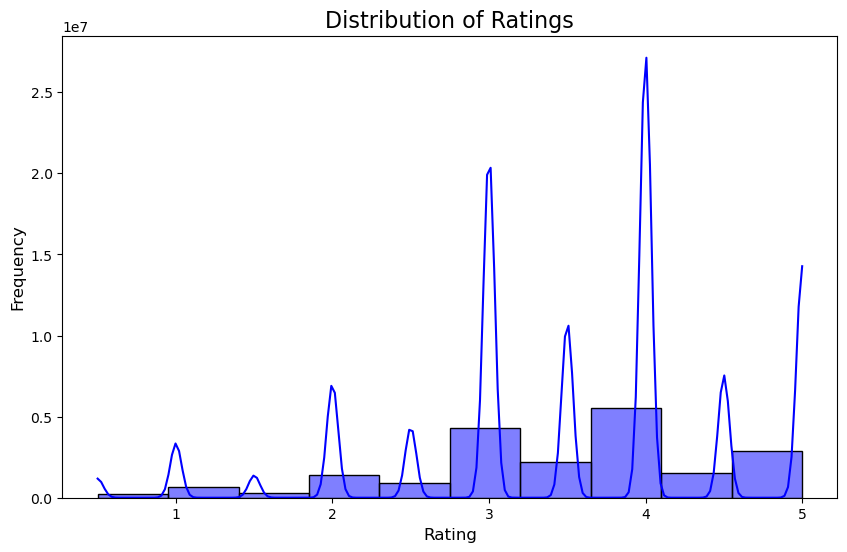

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=10, kde=True, color='blue')
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


## 3- Preprocessing 

In [16]:
pd.DataFrame(df.title.value_counts())


,title
Pulp Fiction (1994),67310
Forrest Gump (1994),66172
"Shawshank Redemption, The (1994)",63366
"Silence of the Lambs, The (1991)",63299
Jurassic Park (1993),59715
...,...
Rapture (Arrebato) (1980),1
"Education of Mohammad Hussein, The (2013)",1
Satanas (2007),1
Psychosis (2010),1


In [17]:
unique_movies =pd.DataFrame(df['title'].value_counts())
unique_movies

,title
Pulp Fiction (1994),67310
Forrest Gump (1994),66172
"Shawshank Redemption, The (1994)",63366
"Silence of the Lambs, The (1991)",63299
Jurassic Park (1993),59715
...,...
Rapture (Arrebato) (1980),1
"Education of Mohammad Hussein, The (2013)",1
Satanas (2007),1
Psychosis (2010),1


In [18]:
movie_rating_avg = df.groupby('title')['rating'].mean().sort_values(ascending=False).reset_index().rename(columns={'rating':'Average_rating'})
movie_rating_avg.head()

,title,Average_rating
0,Small Roads (2011),5.0
1,Divorce (1945),5.0
2,The Beautiful Story (1992),5.0
3,Into the Middle of Nowhere (2010),5.0
4,The Sea That Thinks (2000),5.0


In [19]:
movie_rating_count = df.groupby('title')['rating'].count().sort_values(ascending =False).reset_index().rename(columns={'rating':'Total_RatingCount'})
movie_rating_count

,title,Total_RatingCount
0,Pulp Fiction (1994),67310
1,Forrest Gump (1994),66172
2,"Shawshank Redemption, The (1994)",63366
3,"Silence of the Lambs, The (1991)",63299
4,Jurassic Park (1993),59715
...,...,...
27257,"North and South, Book I (1985)",0
27258,"North and South, Book II (1986)",0
27259,The Happy Road (1957),0
27260,Angele (1934),0


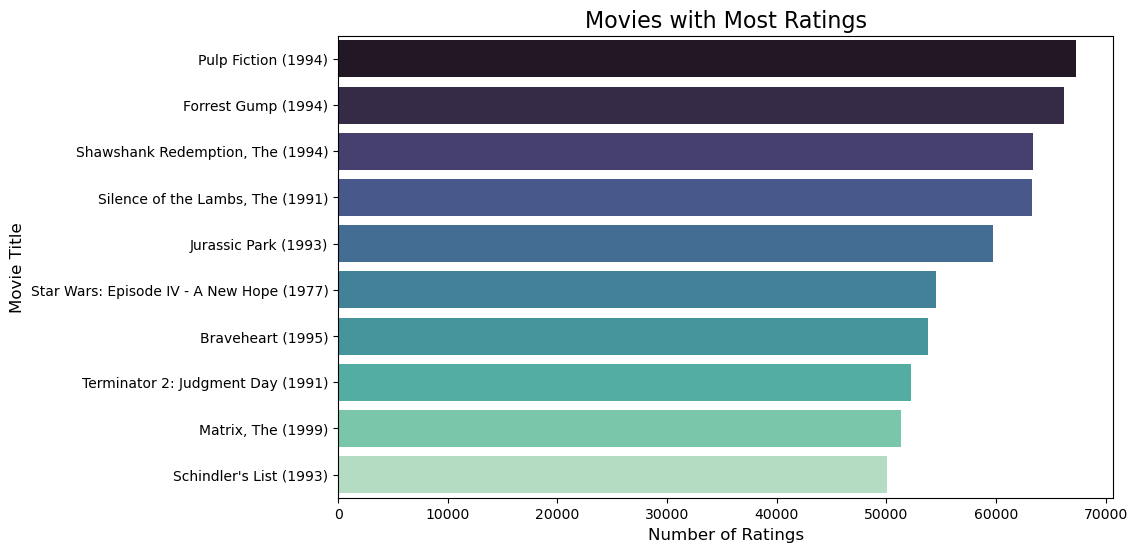

In [20]:
most_rated = movie_rating_count.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Total_RatingCount', y='title', data=most_rated, palette='mako')
plt.title('Movies with Most Ratings', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.show()


In [21]:
movie_rate_count_avg = movie_rating_count.merge(movie_rating_avg,on='title')
movie_rate_count_avg.head()

,title,Total_RatingCount,Average_rating
0,Pulp Fiction (1994),67310,4.174231
1,Forrest Gump (1994),66172,4.029000
2,"Shawshank Redemption, The (1994)",63366,4.446990
3,"Silence of the Lambs, The (1991)",63299,4.177057
4,Jurassic Park (1993),59715,3.664741


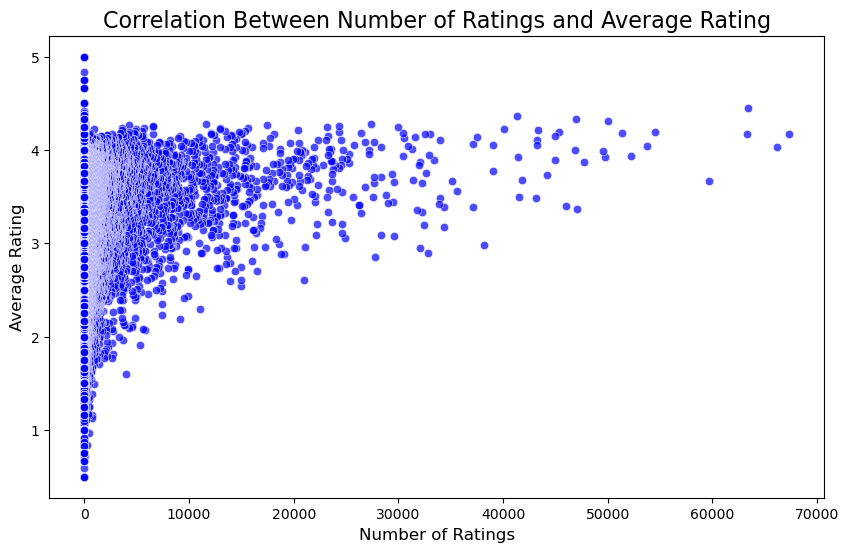

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=movie_rate_count_avg, x='Total_RatingCount', y='Average_rating', alpha=0.7, color='blue')
plt.title('Correlation Between Number of Ratings and Average Rating', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.show()


In [23]:
rare_movie = unique_movies[unique_movies['title'] <=10000].index # remove any movie with less than 1000 rating
movies_df =df[~df['title'].isin(rare_movie)]
movies_df

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6.0,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.5,2009-01-02 01:13:41
...,...,...,...,...,...,...
19985698,114240,Aladdin (1992),Adventure|Animation|Children|Comedy|Fantasy,28195.0,4.0,2014-09-22 20:52:18
19985699,114240,Aladdin (1992),Adventure|Animation|Children|Comedy|Fantasy,51334.0,3.0,2014-09-23 15:53:39
19985700,114240,Aladdin (1992),Adventure|Animation|Children|Comedy|Fantasy,120575.0,2.5,2014-10-08 14:23:39
19985701,114240,Aladdin (1992),Adventure|Animation|Children|Comedy|Fantasy,124998.0,2.5,2014-09-20 22:16:14


In [24]:
features = movies_df.pivot_table(index='title',columns='userId',values='rating').fillna(0)
features 

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,138484.0,138485.0,138486.0,138487.0,138488.0,138489.0,138490.0,138491.0,138492.0,138493.0
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12 Angry Men (1957),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,4.0
2001: A Space Odyssey (1968),3.5,5.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28 Days Later (2002),3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300 (2007),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"X-Files: Fight the Future, The (1998)",0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-Men (2000),0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,4.5
X2: X-Men United (2003),4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,4.5


### 4- Model trainning with KNN


In [25]:
# Train the NearestNeighbors Model
def train_model(movie_rating_feature):
    sparse_matrix = csr_matrix(movie_rating_feature.values) # crs_ matrix to handle 0 ratings or null ratings
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_jobs=-1) #intializing Knn parameters used in recmmendation systems
    model_knn.fit(sparse_matrix)
    return model_knn

## 5- Testing 

In [26]:
def recommended_movie(movie_rating_feature, model_knn, movie_name):
    
   # check if the movie is in the dataset
    try:
        query_index = movie_rating_feature.index.get_loc(movie_name)
    except KeyError:
        print(f"Movie '{movie_name}' not found in the dataset.")
        return
    
    distances, indices = model_knn.kneighbors(
        movie_rating_feature.iloc[query_index].values.reshape(1, -1),  
        n_neighbors=6 # return 6 ecommendations
    )
    
    # iterate throug the index of the movies to get the movie title 
    print(f"\nRecommendations for '{movie_name}':")
    for i, index in enumerate(indices.flatten()):
        recommendation = movie_rating_feature.index[index]
        distance = distances.flatten()[i]
        prefix = "Selected Movie:" if i == 0 else f"{i}:" # assign the movie and the recommmendation
        print(f"{prefix} {recommendation} (Distance: {distance:.2f})")


In [27]:
# Train the model
model_knn = train_model(features)

    
recommended_movie(features, model_knn, movie_name="Batman (1989)")



Recommendations for 'Batman (1989)':
Selected Movie: Batman (1989) (Distance: 0.00)
1: Batman Forever (1995) (Distance: 0.28)
2: True Lies (1994) (Distance: 0.32)
3: Jurassic Park (1993) (Distance: 0.34)
4: Fugitive, The (1993) (Distance: 0.34)
5: Apollo 13 (1995) (Distance: 0.36)


- List of some movies we can try 

In [29]:
available_movies = features.index.tolist()

print("Movies available for recommendations:")
for movie in available_movies[:50]:
    print(movie)


Movies available for recommendations:
10 Things I Hate About You (1999)
12 Angry Men (1957)
2001: A Space Odyssey (1968)
28 Days Later (2002)
300 (2007)
A.I. Artificial Intelligence (2001)
Abyss, The (1989)
Ace Ventura: Pet Detective (1994)
Ace Ventura: When Nature Calls (1995)
Addams Family Values (1993)
Adventures of Priscilla, Queen of the Desert, The (1994)
African Queen, The (1951)
Air Force One (1997)
Airplane! (1980)
Aladdin (1992)
Alien (1979)
Alien: Resurrection (1997)
Aliens (1986)
Alien³ (a.k.a. Alien 3) (1992)
Almost Famous (2000)
Amadeus (1984)
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
American Beauty (1999)
American History X (1998)
American Pie (1999)
American President, The (1995)
Animal House (1978)
Annie Hall (1977)
Antz (1998)
Apocalypse Now (1979)
Apollo 13 (1995)
Arachnophobia (1990)
Armageddon (1998)
Army of Darkness (1993)
As Good as It Gets (1997)
Austin Powers: International Man of Mystery (1997)
Austin Powers: The Spy Who Shagged Me (1999)
Babe (199